In [1]:
from studies.study_factory import StudyFactory
from dataloader.dataloader import DataLoader

dataloader = DataLoader(
    buffer_size=10,
    max_cache_size_gb=100,
    cache_dir="cache",
    notch_filter=True,
    frequency_bands={"all": (0.5, 100)},
    scaling="both",
    brain_clipping=20,
    baseline_window=0.5,
    delay=0.15,
    new_freq=100,
    batch_types={"audio": 2},
    batch_kwargs={
        "audio": {
            "max_random_shift": 1,
            "window_size": 30,
            "window_stride": 1,
            "audio_sample_rate": 16000,
            "hop_length": 160,
            "audio_processor": "openai/whisper-large-v3",
        }
    },
)

2025-01-16 14:32:13,284	INFO worker.py:1821 -- Started a local Ray instance.


In [2]:
study = StudyFactory.create_study(
    study_name="gwilliams2023",
    batch_type="audio",
    path="data/gwilliams2023",
    cache_enabled=True,
    max_cache_size=200,  # in items
    cache_name="cache",
)

Loading Gwilliams2023 with batch type audio


In [3]:
from itertools import chain
import random

flat_recordings = list(chain.from_iterable(chain.from_iterable(study.recordings)))

In [4]:
# # Start background fetching
import time


dataloader.start_fetching([flat_recordings[0]], cache=True)

# Process batches as they become available
try:
    batches, recs, start_time = 0, 0, time.time()
    print(f"Total recordings: {len(flat_recordings)}")

    while True:
        batch = dataloader.get_recording()

        if batch is None:
            break

        brain = batch.brain_segments["all"]
        batches += brain.shape[0]
        recs += 1

        if recs % 1 == 0:
            print(
                f"Batch {batches} ({recs} recordings) processed in {time.time() - start_time:.2f}s"
            )
            print(
                f"Average processing time per recording: {(time.time() - start_time) / recs:.2f}s"
            )
            print(
                f"Average processing time per batch: {(time.time() - start_time) / batches:.2f}s"
            )

        break


except KeyboardInterrupt:
    print("Interrupted")
    dataloader.stop()
except Exception as e:
    print("Error", e)
    dataloader.stop()

Total recordings: 196
Batch 134 (1 recordings) processed in 1.95s
Average processing time per recording: 1.95s
Average processing time per batch: 0.01s


In [13]:
from filecmp import cmp
from torchaudio import transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch


n_fft = 256
spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    hop_length=1,
    normalized=True,
    power=1,
)

spec = spectrogram_transform(batch.brain_segments["all"][:1])
print(spec.shape)
spec = torch.log1p(spec)

torch.Size([1, 208, 129, 3001])


Tensor size: 0.322091328 GB


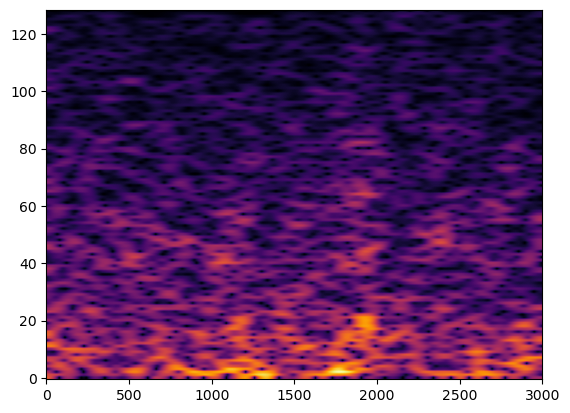

In [14]:
plt.imshow(spec[0][0].numpy(), aspect="auto", origin="lower", cmap="inferno")
print("Tensor size:", spec.numel() * spec.element_size() / 1e9, "GB")

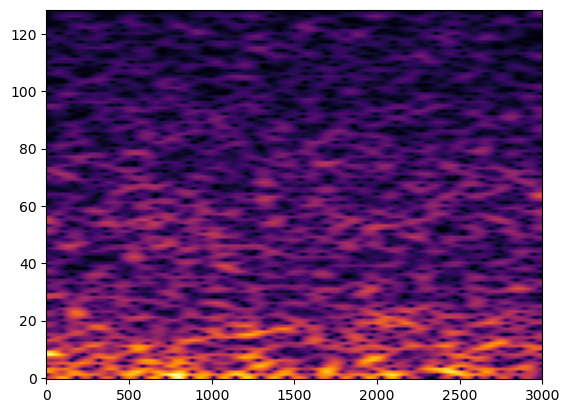

In [15]:
plt.imshow(spec[0][8].numpy(), aspect="auto", origin="lower", cmap="inferno")

Frames shape: (3001, 129, 208)


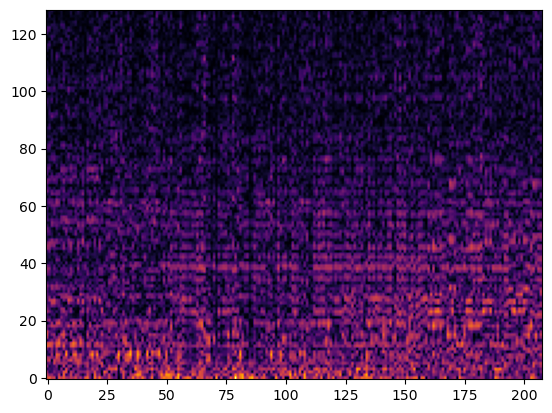

Animation saved as animation.mp4


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming spec[0] has shape [num_frames, height, width]
frames = spec[0].transpose(0, 2).numpy()  # Shape: [num_frames, height, width]
print("Frames shape:", frames.shape)

# Normalize frames to [0, 1] for display
frames = (frames - frames.min()) / (frames.max() - frames.min())

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(frames[0], aspect="auto", origin="lower", cmap="inferno")


def update(frame):
    im.set_array(frame)
    return [im]


# Create the animation (set blit=False if it causes issues)
ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=False)

# Display the animation
plt.show()

ani.save("nfft256.mp4", writer="ffmpeg", fps=100)
print("Animation saved as animation.mp4")

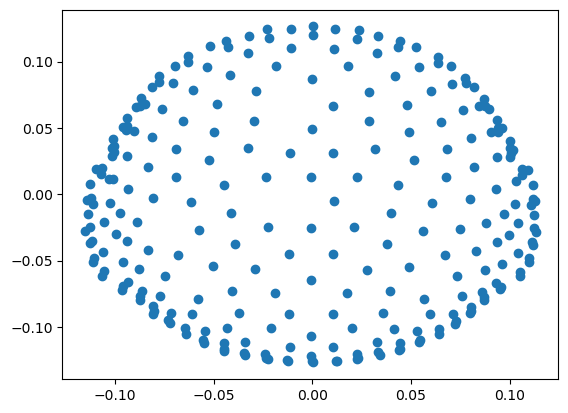

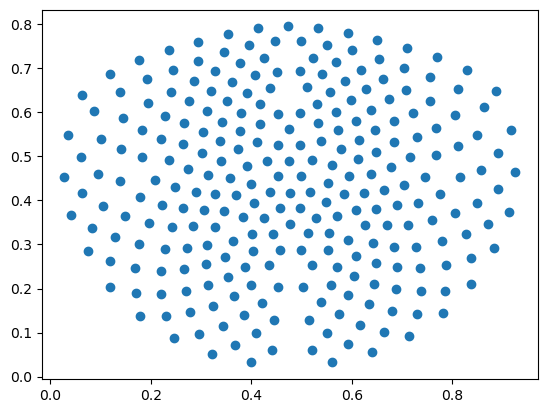

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import mne

# Plot sensor locations

locs = [ch["loc"][:3] for ch in batch.recording.info["chs"]]
locs = np.array(locs)
plt.scatter(locs[:, 0], locs[:, 1])
plt.show()

layout = mne.find_layout(batch.recording.info)
layout = layout.pos[:269, :2]
plt.scatter(layout[:, 0], layout[:, 1])
plt.show()